# 데이콘 전력 사용량 예측

- 건물 정보와 기후 정보를 활용하여 전력량을 예측하라.

***
#### train.csv : <br>
train 데이터 : 60개 건물들의 2020년 6월 1일 부터 2020년 8월 24일까지의 데이터 <br>
1시간 단위로 제공 <br>
전력사용량(kWh) 포함 <br>
train.shape: (122400, 10) <br>



#### test.csv : <br>
test 데이터 : 60개 건물들의 2020년 8월 25일 부터 2020년 8월 31일까지의 데이터 <br>
3시간 단위로 제공(강수량의 경우 6시간 단위로 제공, 예보데이터) <br>
전력사용량(kWh) 미포함 <br>
test.shape: (10080, 9)





#### sample_submission.csv : <br>
sample_submission 데이터 <br>
sample_submission.shape: (10080, 2) <br>
***

#### 평가 산식 

- SMAPE(Symmetric Mean Absolute Percentage Error) 사용

MAPE의 경우 Actual 값이 0이거나 작은 경우 MAPE 값이 지나치게 커지는 문제가 있으며, 이를 개선한게 SMAPE
***

현재까지 관심 변수

1. 전력 사용량 : 전력 사용량을 예측하는 문제이기 때문에 최우선시 해야할 것이다.


2. 시간(date time) : 시간별 전력 사용량에 따라 항상 전력 소모량이 많은 공장이라던지 특정 시간대 전력 소모량이 많은 학교나 사무실 같이 건물의 종류를 유추해볼 수 있을 것이다.


3. 날씨 데이터 : 보통 습도가 높거나 기온이 높으면 전력 사용량이 올라간다. 고려해볼만하다.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 한글폰트 설정
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    print('Mac version')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    print('Windows version')
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumFont/NanumGothicBold.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
    print('Linux version')
else:
    print('Unknown system... sorry~~~~')

Windows version


##  1. 데이터 파악

In [2]:
# 사용할 패키지
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import date

In [3]:
# 데이터 불러오기
root = "./"
train_df = pd.read_csv(root+"datasets/train.csv", encoding = 'CP949')
test_df = pd.read_csv(root+"datasets/test.csv", encoding = 'CP949')

In [4]:
submission_df = pd.read_csv(root+"datasets/sample_submission.csv", encoding = 'CP949')

In [5]:
train_df.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [6]:
test_df.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64
 3   풍속(m/s)       3360 non-null   float64
 4   습도(%)         3360 non-null   float64
 5   강수량(mm, 6시간)  1680 non-null   float64
 6   일조(hr, 3시간)   3360 non-null   float64
 7   비전기냉방설비운영     2296 non-null   float64
 8   태양광보유         1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


#### 총 122400개의 데이터를 담고있다  (60개의 건물 x 85일 x 24시간 = 122400)

In [9]:
train_df.isnull().sum()

num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64

In [10]:
test_df.isnull().sum()

num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64

#### test set에는 null값이 다수 존재

### test 데이터 결측치 처리

In [11]:
#건물별로 비전기냉방설비운영과 태양광보유를 판단해 test set의 결측치를 보간
train_df[['num', '비전기냉방설비운영','태양광보유']]
ice={}
hot={}
count=0
for i in range(0, len(train_df), len(train_df)//60):
    count +=1
    ice[count]=train_df.loc[i,'비전기냉방설비운영']
    hot[count]=train_df.loc[i,'태양광보유']

for i in range(len(test_df)):
    test_df.loc[i, '비전기냉방설비운영']=ice[test_df['num'][i]]
    test_df.loc[i, '태양광보유']=hot[test_df['num'][i]]

In [12]:
# 기온, 풍속, 습도 등, 기타 결측치는 선형 보간 진행
test_df = test_df.interpolate(method='values').round(1) 
test_df.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,0.0,0.0
1,1,2020-08-25 01,27.6,1.4,75.3,0.0,0.0,0.0,0.0
2,1,2020-08-25 02,27.5,1.2,76.7,0.0,0.0,0.0,0.0
3,1,2020-08-25 03,27.3,1.1,78.0,0.0,0.0,0.0,0.0
4,1,2020-08-25 04,26.9,1.2,79.7,0.0,0.0,0.0,0.0


In [13]:
# 변수명 간단하게 변경
train_df.columns = ['num', 'date_time', '전력사용량', '기온', '풍속', '습도',
       '강수량', '일조', '비전기냉방설비운영', '태양광보유']
train_df.head()

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [14]:
test_df.columns = ['num', 'date_time', '기온', '풍속', '습도',
       '강수량', '일조', '비전기냉방설비운영', '태양광보유']
test_df.head()

,num,date_time,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,0.0,0.0
1,1,2020-08-25 01,27.6,1.4,75.3,0.0,0.0,0.0,0.0
2,1,2020-08-25 02,27.5,1.2,76.7,0.0,0.0,0.0,0.0
3,1,2020-08-25 03,27.3,1.1,78.0,0.0,0.0,0.0,0.0
4,1,2020-08-25 04,26.9,1.2,79.7,0.0,0.0,0.0,0.0


## 2. 시간별, 날짜별, 주말 변수 추가

- 건물의 시간대별 사용량 파악을 위해 date_time을 날짜, 요일, 평일/주말로 구분

In [15]:
# 날짜만 남기기
def date_change(x) : 
    return pd.to_datetime(x[:-3])


train_df['date'] = train_df.date_time.apply(lambda x : date_change(x))
test_df['date'] = test_df.date_time.apply(lambda x : date_change(x))

In [16]:
# 시간대별 분리
def hour_change(x) :
    return int(x[11:13])

train_df['hour'] = train_df.date_time.apply(lambda x : hour_change(x))
test_df['hour'] = test_df.date_time.apply(lambda x : hour_change(x))

In [17]:
# 요일별 추출
def week(x) :
    return pd.to_datetime(x[:-3]).weekday()

train_df['week'] = train_df.date_time.apply(lambda x : week(x))
test_df['week'] = test_df.date_time.apply(lambda x : week(x))

In [18]:
# 0~4 : 평일, 5~6 : 주말
train_df.week.unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [19]:
# 주말인 경우 1 주말이 아닌 경우 0
train_df['weekend'] = train_df.week.apply(lambda x : 1 if x > 4 else 0)
test_df['weekend'] = test_df.week.apply(lambda x : 1 if x > 4 else 0)

In [20]:
train_df['days_count'] = train_df.date.dt.dayofyear
test_df['days_count'] = test_df.date.dt.dayofyear

In [21]:
train_df.head()

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,date,hour,week,weekend,days_count
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01,0,0,0,153
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01,1,0,0,153
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,2,0,0,153
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,3,0,0,153
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01,4,0,0,153


###  시각화


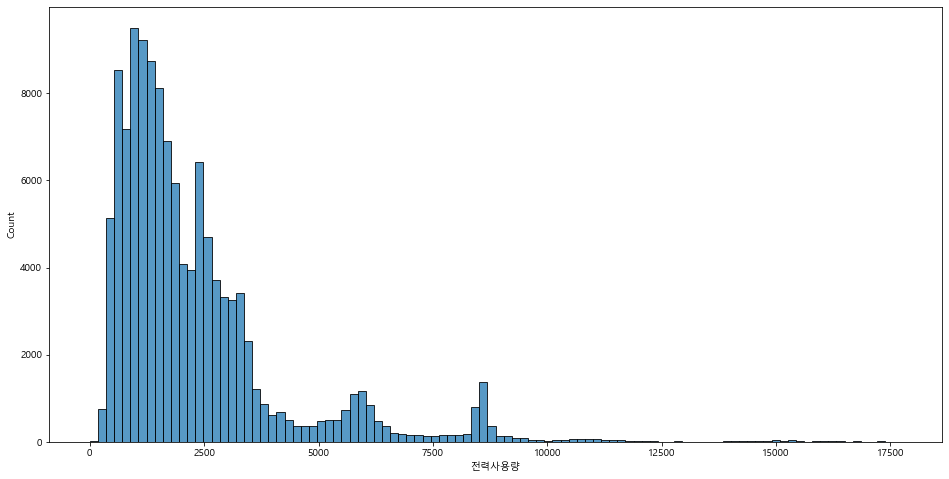

In [22]:
# 전력사용량 분포 시각화
plt.figure(figsize = (16,8))
sns.histplot(train_df.전력사용량, bins = 100)
plt.show()

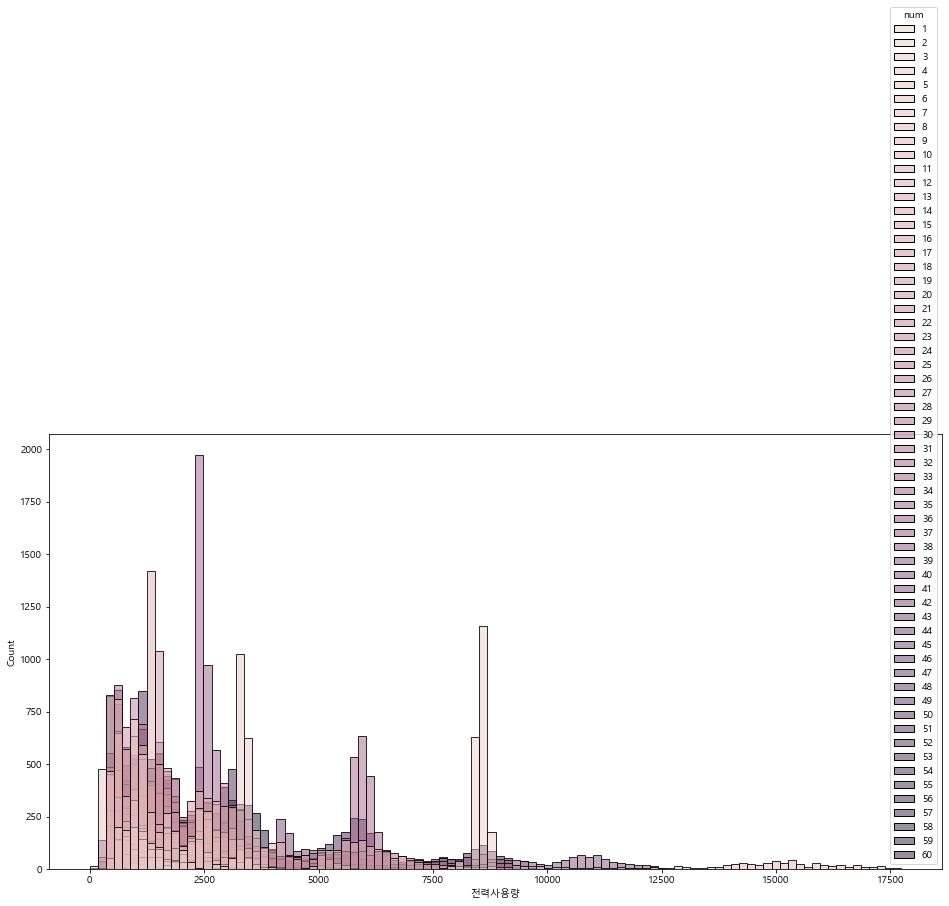

In [23]:
# 건물별 시각화 
plt.figure(figsize = (16,8))
sns.set_palette("pastel")
sns.histplot(data = train_df, x = '전력사용량', hue = 'num',bins = 100)

plt.show()

#### 건물별 전력 사용량에 차이가 있는지 확인해 본 결과, 건물마다 전력 사용량에 차이가 있어보이며 공통적인 특성에 따라 묶어볼 필요가 있어보인다.

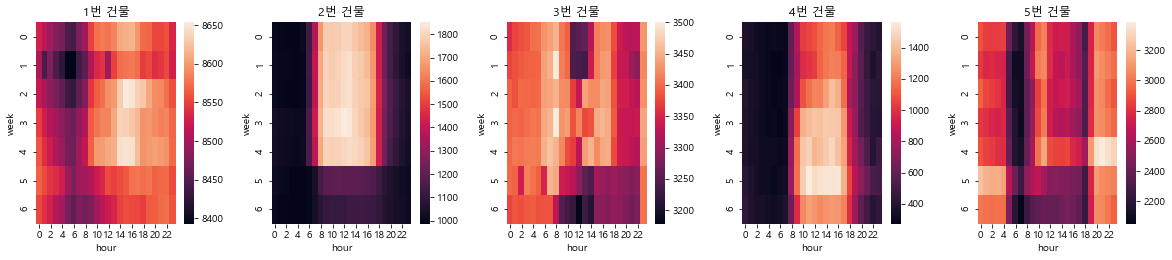

In [24]:
# 1~5번까지의 건물(num 1 ~ 5)들의 전력 사용량 분포 확인 
plt.figure(figsize = (20,3.5))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.35)
for i in train_df['num'].unique()[0:5] :
    num1 = train_df[train_df['num'] == i]
    num1 = num1.groupby(['week','hour'])['전력사용량'].mean().reset_index().pivot('week','hour','전력사용량')
    plt.subplot(1,5,i)
    plt.title("{}번 건물".format(i))
    sns.heatmap(num1)
plt.show()

#### 1번 건물: 5개의 건물 중 요일에 상관없이 항상 높은 전력 사용량(8400~8900)을 보이며 오전 오후에 가장 높은 전력량 사용(24시 공장 추측)

#### 2번 건물: 주말엔 전력 사용량이 거의 없으며 오전 7시부터 오후 6시까지 높은 전력량 사용(학교, 사무실 추측)

#### 3번 건물: 1번 만큼은 아니지만 항시 높은 전력 사용량(3200 ~ 3500)

#### 4번 건물: 야간에는 거의 전력 사용량이 없으며, 목, 금, 토 10 ~ 18시의 전력 사용량이 높게 나옴.

#### 5번 건물: 평일 저녁과 금~토일 전력사용량이 다른 시간대에 비해 높게 나옴.(술집 추측)

## 3. 시간대별 비슷한 전력 사용량의 건물 군집화

- 시간대별 특징들을 담은 클러스터별로 60개의 건물을 군집화 진행.

***
**1. 시간대별 요일별 그룹화**

**2. 광범위한 전력 사용량 스케일 조절**

**3. kmeans를 사용하여 건물 군집화**
***

In [25]:
# 건물별, 요일별 평균 전력 사용량
df_week = train_df.groupby(['num','week']).mean('전력사용량').reset_index().pivot('num','week','전력사용량')

In [26]:
# 건물별, 시간별 평균 전력 사용량
df_hour = train_df.groupby(['num','hour']).mean('전력사용량').reset_index().pivot('num','hour','전력사용량')

In [27]:
df_week.head()

week,0,1,2,3,4,5,6
num,,,,,,,
1,8541.545538,8507.432250,8551.757250,8561.101500,8570.308500,8543.843125,8527.070250
2,1373.904346,1383.035625,1389.466125,1402.357500,1390.788000,1093.347000,1060.336125
3,3371.143240,3371.748507,3398.873622,3406.395846,3402.517822,3340.100728,3308.713665
4,684.863829,678.183456,727.799464,794.561580,825.467101,877.090723,766.609781
5,2720.551846,2703.939000,2698.137000,2685.795000,2838.414000,2744.958000,2609.269500


In [28]:
df_week = df_week.reset_index()
df_hour = df_hour.reset_index()

In [29]:
df_week.head()

week,num,0,1,2,3,4,5,6
0,1,8541.545538,8507.432250,8551.757250,8561.101500,8570.308500,8543.843125,8527.070250
1,2,1373.904346,1383.035625,1389.466125,1402.357500,1390.788000,1093.347000,1060.336125
2,3,3371.143240,3371.748507,3398.873622,3406.395846,3402.517822,3340.100728,3308.713665
3,4,684.863829,678.183456,727.799464,794.561580,825.467101,877.090723,766.609781
4,5,2720.551846,2703.939000,2698.137000,2685.795000,2838.414000,2744.958000,2609.269500


In [30]:
# num 제거
df_week = df_week.drop('num',axis = 1)
df_hour = df_hour.drop('num',axis = 1)

In [31]:
# 합치기
df_all = pd.concat([df_week, df_hour],axis = 1)
df_all_copy = df_all.copy()

In [32]:
df_all

,0,1,2,3,4,5,6,0,1,2,...,14,15,16,17,18,19,20,21,22,23
0,8541.545538,8507.432250,8551.757250,8561.101500,8570.308500,8543.843125,8527.070250,8540.373176,8517.174776,8509.055718,...,8600.431341,8606.705506,8607.193412,8597.191341,8580.187906,8581.646965,8572.918024,8573.062871,8573.848094,8553.645741
1,1373.904346,1383.035625,1389.466125,1402.357500,1390.788000,1093.347000,1060.336125,1016.083059,1006.713741,1003.755812,...,1612.163012,1598.638871,1578.684282,1520.958918,1344.230259,1197.686965,1128.065082,1087.279200,1048.265788,1029.866400
2,3371.143240,3371.748507,3398.873622,3406.395846,3402.517822,3340.100728,3308.713665,3383.537538,3389.803091,3384.955357,...,3339.620075,3388.781191,3399.378719,3397.013452,3357.859302,3326.849488,3321.474264,3310.769842,3310.322347,3423.915389
3,684.863829,678.183456,727.799464,794.561580,825.467101,877.090723,766.609781,390.832518,358.194071,340.319435,...,1342.630588,1370.918965,1340.840287,1222.466994,939.888784,775.130109,601.744276,506.216200,419.447133,435.779153
4,2720.551846,2703.939000,2698.137000,2685.795000,2838.414000,2744.958000,2609.269500,2950.931012,2904.290259,2888.372329,...,2645.913600,2665.561976,2587.059953,2536.200847,2342.090541,2810.038024,3119.609224,3102.319059,3054.992188,3003.314824
5,1360.713462,1387.191562,1397.536875,1420.080000,1363.089375,700.644375,644.938125,625.307294,603.472235,592.475294,...,1971.749647,1990.154118,1912.444941,1743.294706,1296.247765,1036.298118,890.536235,771.501176,694.522588,650.935059
6,1713.551068,1739.770085,1742.421445,1754.745388,1725.808552,1020.232246,977.905313,1431.963443,1386.630754,1316.141819,...,1983.447111,1983.119426,1900.013883,1813.003941,1498.494626,1262.674694,1104.187492,946.219431,795.412084,1419.522141
7,9802.109005,10089.995499,10092.764069,10174.166041,9950.387163,5781.046741,5890.684579,5751.969625,5683.227246,5678.894374,...,12575.111034,12465.692699,12525.834569,11542.048065,8537.419526,7562.370413,7068.062091,6684.081716,6314.676443,6079.819256
8,1251.729692,1255.232942,1261.113000,1254.965625,1266.738375,1266.147000,1242.697125,1293.354635,1288.044847,1282.680424,...,1221.173852,1234.179547,1256.331207,1273.544457,1286.923064,1300.034870,1299.084089,1300.889725,1297.880637,1294.270867
9,1280.171886,1443.655199,1432.642765,1435.489290,1494.744877,1466.970188,1448.723625,439.568894,433.797882,425.053694,...,2622.203671,2581.561012,2559.877372,2548.891093,2497.412187,1984.095953,1086.040376,639.254003,531.531265,468.412518


In [33]:
# 컬럼명 변경
df_all.columns = ['day' + str(i) for i in range(0,7)] + ['hour' + str(i) for i in range(0,24)]

In [34]:
df_all

,day0,day1,day2,day3,day4,day5,day6,hour0,hour1,hour2,...,hour14,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23
0,8541.545538,8507.432250,8551.757250,8561.101500,8570.308500,8543.843125,8527.070250,8540.373176,8517.174776,8509.055718,...,8600.431341,8606.705506,8607.193412,8597.191341,8580.187906,8581.646965,8572.918024,8573.062871,8573.848094,8553.645741
1,1373.904346,1383.035625,1389.466125,1402.357500,1390.788000,1093.347000,1060.336125,1016.083059,1006.713741,1003.755812,...,1612.163012,1598.638871,1578.684282,1520.958918,1344.230259,1197.686965,1128.065082,1087.279200,1048.265788,1029.866400
2,3371.143240,3371.748507,3398.873622,3406.395846,3402.517822,3340.100728,3308.713665,3383.537538,3389.803091,3384.955357,...,3339.620075,3388.781191,3399.378719,3397.013452,3357.859302,3326.849488,3321.474264,3310.769842,3310.322347,3423.915389
3,684.863829,678.183456,727.799464,794.561580,825.467101,877.090723,766.609781,390.832518,358.194071,340.319435,...,1342.630588,1370.918965,1340.840287,1222.466994,939.888784,775.130109,601.744276,506.216200,419.447133,435.779153
4,2720.551846,2703.939000,2698.137000,2685.795000,2838.414000,2744.958000,2609.269500,2950.931012,2904.290259,2888.372329,...,2645.913600,2665.561976,2587.059953,2536.200847,2342.090541,2810.038024,3119.609224,3102.319059,3054.992188,3003.314824
5,1360.713462,1387.191562,1397.536875,1420.080000,1363.089375,700.644375,644.938125,625.307294,603.472235,592.475294,...,1971.749647,1990.154118,1912.444941,1743.294706,1296.247765,1036.298118,890.536235,771.501176,694.522588,650.935059
6,1713.551068,1739.770085,1742.421445,1754.745388,1725.808552,1020.232246,977.905313,1431.963443,1386.630754,1316.141819,...,1983.447111,1983.119426,1900.013883,1813.003941,1498.494626,1262.674694,1104.187492,946.219431,795.412084,1419.522141
7,9802.109005,10089.995499,10092.764069,10174.166041,9950.387163,5781.046741,5890.684579,5751.969625,5683.227246,5678.894374,...,12575.111034,12465.692699,12525.834569,11542.048065,8537.419526,7562.370413,7068.062091,6684.081716,6314.676443,6079.819256
8,1251.729692,1255.232942,1261.113000,1254.965625,1266.738375,1266.147000,1242.697125,1293.354635,1288.044847,1282.680424,...,1221.173852,1234.179547,1256.331207,1273.544457,1286.923064,1300.034870,1299.084089,1300.889725,1297.880637,1294.270867
9,1280.171886,1443.655199,1432.642765,1435.489290,1494.744877,1466.970188,1448.723625,439.568894,433.797882,425.053694,...,2622.203671,2581.561012,2559.877372,2548.891093,2497.412187,1984.095953,1086.040376,639.254003,531.531265,468.412518


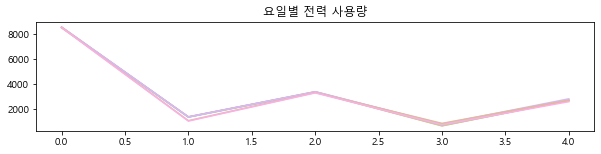

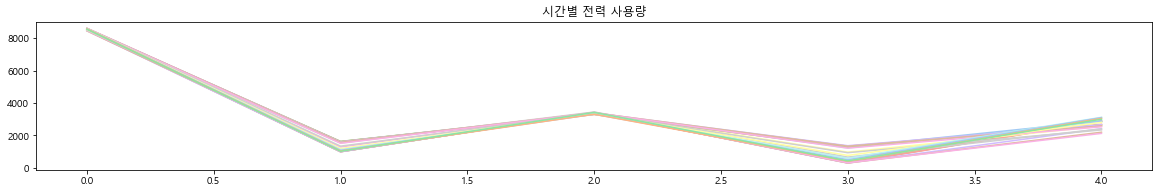

In [35]:
# 요일별 시간별 전력 사용량 시각화
plt.figure(figsize = (10,5))
plt.subplots_adjust(hspace = 0.5)
plt.subplot(2,1,1)
plt.plot(df_all.iloc[:5,:7])
plt.title("요일별 전력 사용량")

plt.figure(figsize = (20,6))
plt.subplot(2,1,2)
plt.plot(df_all.iloc[:5,8:])
plt.title("시간별 전력 사용량")

plt.show()

그래프 y축 범위가 너무 넓어 건물별 특성이 보이질 않음.

### 표준화 진행

In [36]:
# 표준화 진행
for i in range(len(df_all)) :
    df_all.iloc[i,:7] = (df_all.iloc[i,:7] - df_all.iloc[i,:7].mean())/df_all.iloc[i,:7].std()
    df_all.iloc[i,7:] = (df_all.iloc[i,7:] - df_all.iloc[i,7:].mean())/df_all.iloc[i,7:].std()    

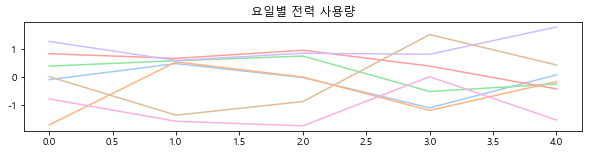

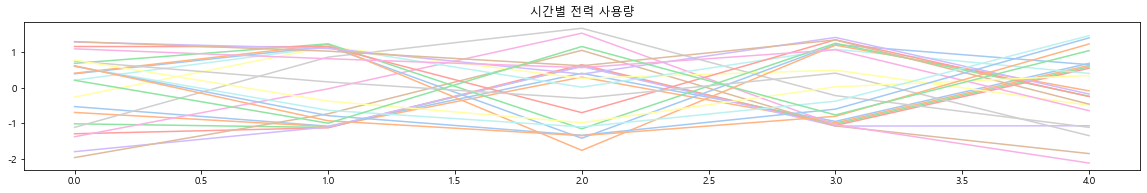

In [37]:
plt.figure(figsize = (10,5))
plt.subplots_adjust(hspace = 0.5)
plt.subplot(2,1,1)
plt.plot(df_all.iloc[:5,:7])
plt.title("요일별 전력 사용량")

plt.figure(figsize = (20,6))
plt.subplot(2,1,2)
plt.plot(df_all.iloc[:5,8:])
plt.title("시간별 전력 사용량")

plt.show()

표준화 진행 후 건물 별 전력 사용량의 차이가 보인다.

### 건물 군집화

In [38]:
from sklearn.cluster import KMeans

km_df_k = [KMeans(n_clusters = k, random_state = 42).fit(df_all) for k in range(1,10)]

In [39]:
# 클러스터 개수 별 inertia 저장
df_inertias = [model.inertia_ for model in km_df_k]

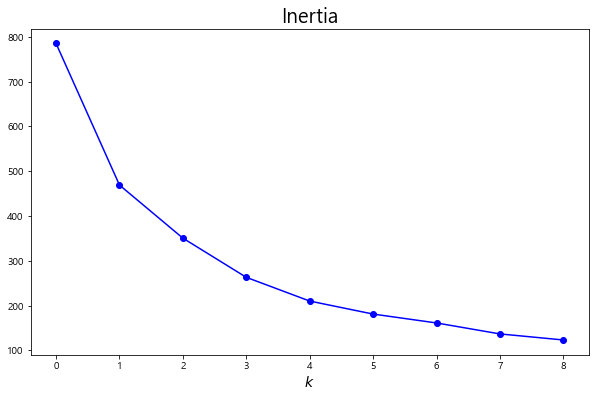

In [40]:
# inertia 시각화
plt.figure(figsize = (10,6))
plt.plot(df_inertias, 'b-o')
plt.title("Inertia", fontsize = 20)
plt.xlabel("$k$", fontsize = 14)
plt.show()

이너셔로는 최적의 클러스터 개수(Elbow) 파악이 애매하다.

In [41]:
# 실루엣 점수 추가 진행
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(df_all, model.labels_) for model in km_df_k[1:]]

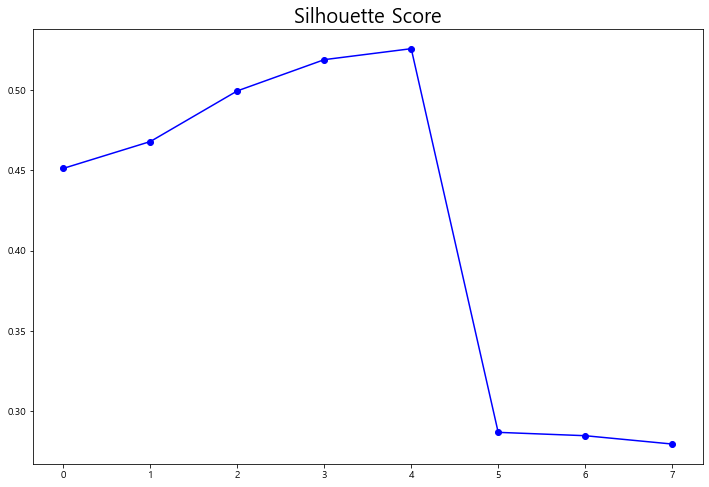

In [42]:
plt.figure(figsize = (12,8))
plt.plot(silhouette_scores, 'b-o')
plt.title("Silhouette Score", fontsize = 20)
plt.show()

실루엣 점수를 기반으로 k = 4로 클러스터링을 진행했다.

In [43]:
km = KMeans(n_clusters = 4, random_state = 42)

df_km = km.fit(df_all)

In [44]:
df_pred = df_km.predict(df_all)
df_all['pred'] = df_pred

### 군집별 특징 잡기

- 예측한 군집 레이블별로 시각화

In [45]:
# 군집별 건물 갯수
df_all.pred.value_counts()

0    35
1    14
2     7
3     4
Name: pred, dtype: int64

In [46]:
# 군집 분할
for i in range(len(np.unique(df_pred))) :
    if i == 0 :
        cluster1 = df_all[df_all.pred == 0]
    elif i == 1 :
        cluster2 = df_all[df_all.pred == 1]
    elif i == 2 :
        cluster3 = df_all[df_all.pred == 2]
    elif i == 3 :
        cluster4 = df_all[df_all.pred == 3]

In [47]:
# 군집별 건물 갯수
df_all.pred.value_counts()

0    35
1    14
2     7
3     4
Name: pred, dtype: int64

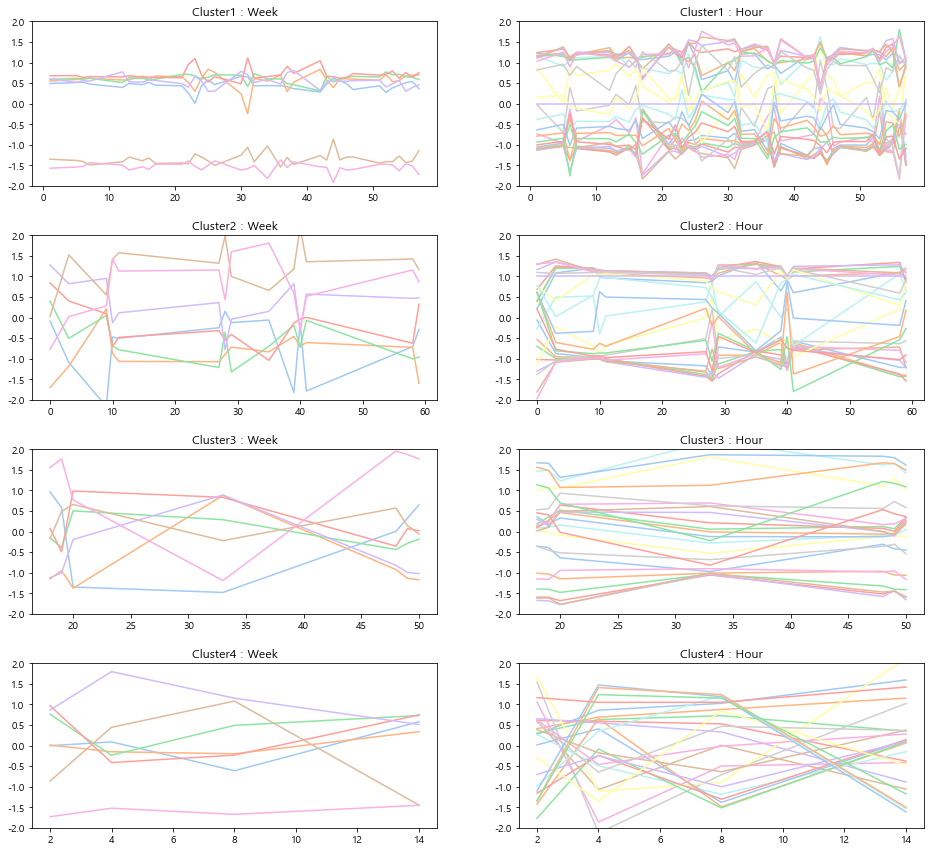

In [48]:
# 시각화
fig = plt.figure(figsize = (16,14))
ax = fig.subplots(4,2)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)


for i in range(0,len([cluster1,cluster2,cluster3,cluster4])) :
    if i == 0 :
        ax[i,0].plot(cluster1.iloc[:,:7])
        ax[i,0].set_title('Cluster1 : Week')
        ax[i,0].set_ylim([-2,2])
        ax[i,1].plot(cluster1.iloc[:,7:])
        ax[i,1].set_title('Cluster1 : Hour')
        ax[i,1].set_ylim([-2,2])
    elif i == 1 :
        ax[i,0].plot(cluster2.iloc[:,:7])
        ax[i,0].set_title('Cluster2 : Week')
        ax[i,0].set_ylim([-2,2])
        ax[i,1].plot(cluster2.iloc[:,7:])
        ax[i,1].set_title('Cluster2 : Hour')
        ax[i,1].set_ylim([-2,2])
    elif i == 2 :
        ax[i,0].plot(cluster3.iloc[:,:7])
        ax[i,0].set_title('Cluster3 : Week')
        ax[i,0].set_ylim([-2,2])
        ax[i,1].plot(cluster3.iloc[:,7:])
        ax[i,1].set_title('Cluster3 : Hour')
        ax[i,1].set_ylim([-2,2])
    elif i == 3 :
        ax[i,0].plot(cluster4.iloc[:,:7])
        ax[i,0].set_title('Cluster4 : Week')
        ax[i,0].set_ylim([-2,2])
        ax[i,1].plot(cluster4.iloc[:,7:])
        ax[i,1].set_title('Cluster4 : Hour')
        ax[i,1].set_ylim([-2,2])
        
plt.show()

### train 데이터에 클러스터값 대입

In [49]:
df_all = df_all.reset_index()

In [50]:
df_all.columns = ['num', 'day0', 'day1', 'day2', 'day3', 'day4', 'day5', 'day6',
       'hour0', 'hour1', 'hour2', 'hour3', 'hour4', 'hour5', 'hour6', 'hour7',
       'hour8', 'hour9', 'hour10', 'hour11', 'hour12', 'hour13', 'hour14',
       'hour15', 'hour16', 'hour17', 'hour18', 'hour19', 'hour20', 'hour21',
       'hour22', 'hour23', 'pred']

In [51]:
df_all['num'] = df_all['num'] + 1

In [52]:
copy_train = train_df.copy()

In [53]:
# train 데이터에 군집 예측값 결합
train_pred = pd.merge(copy_train,df_all[['num','pred']], on = 'num', how = 'right')

In [54]:
print("샘플 클러스터1 비율 :" ,df_all['pred'].value_counts()[0]/df_all['pred'].value_counts().sum())
print("train데이터에 병합시킨 클러스터1 비율 :", train_pred['pred'].value_counts()[0]/train_pred['pred'].value_counts().sum())

샘플 클러스터1 비율 : 0.5833333333333334
train데이터에 병합시킨 클러스터1 비율 : 0.5833333333333334


#### train데이터와 클러스터 예측값으로 요일별, 시간별 시각화 진행, 클러스터별 특징 파악


In [55]:
train_pred

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,date,hour,week,weekend,days_count,pred
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01,0,0,0,153,1
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01,1,0,0,153,1
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,2,0,0,153,1
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,3,0,0,153,1
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01,4,0,0,153,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,2020-08-24,19,0,0,237,1
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,2020-08-24,20,0,0,237,1
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,2020-08-24,21,0,0,237,1
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,2020-08-24,22,0,0,237,1


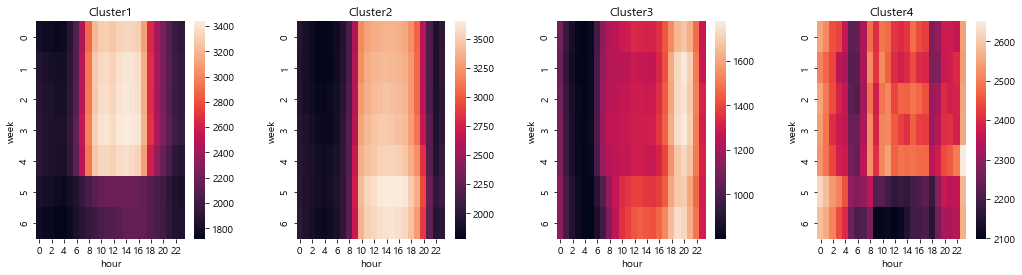

In [56]:
# train_pred 시각화
plt.figure(figsize = (22,4))
plt.subplots_adjust(wspace = 0.4)
for i in range(len(np.unique(train_pred.pred))) :
    times = train_pred[train_pred.pred == i] 
    times = times.groupby(['week','hour'])['전력사용량'].mean().reset_index().pivot('week','hour','전력사용량')
    plt.subplot(1,5,i+1)
    sns.heatmap(times)
    plt.title('Cluster' + str(i+1))
    
plt.show()

#### cluster1 : 평일(0~4) 오전7시  ~ 저녁 6시까지 전력 사용량이 많은 건물(학교, 사무실 추측)

#### cluster2 : 요일 상관없이 오전 10시 ~ 저녁 8시까지 전력 사용량이 많은 건물(식당 추측)

#### cluster3 : 새벽에 전력사용량이 거의 없고 오전대비 야간에 전력 사용량이 많은 건물(술집 같은 상업시설 추측)

#### cluster4 : 항상 전력 사용량이 많은 건물(공장 추측)

## 날씨 데이터 전처리

****
 ◦ 기상청은 지난 7년(2004~2011)간의 기상 거대자료(빅데이터)를 분석한 결과, 전력 사용량에 미치는 기상요소는 기온(평균, 최고, 최저), 습도, 풍속, 운량, 불쾌지수, 체감온도, 강수량 등으로 나타났다.<br>
   ◦ 특히, 여름과 겨울에는 최저기온, 운량, 체감온도와 전력사용량의 상관성이 높고, 환절기(5, 10월)에는 기상요소와 전력사용량의 연관성이 상대적으로 낮은 것으로 나타났다.
   
#### http://web.kma.go.kr/notify/press/kma_list.jsp?bid=press&mode=view&num=1192880

***
#### 날씨 데이터를 활용해 새로운 변수 생성
***
#### https://www.kma.go.kr/HELP/basic/help_01_05.jsp
**불쾌지수** : 1.8 × 온도 - 0.55 (1 - 습도) (1.8 × 온도 - 26) + 32
- 80이상 : 전원 불쾌감을 느낌
- 75 ~ 80미만 : 절반이 불쾌감을 느낌
- 68 ~ 75미만 : 불쾌감이 나타나기 시작
- 68 미만 : 쾌적함을 느낌
***

**비전기냉방설비운영** : 전기냉방설비 운영 여부에 따른 전력소모량 비교

In [57]:
copy_train = train_pred.copy()
copy_test = test_df.copy()

In [58]:
copy_train

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,date,hour,week,weekend,days_count,pred
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01,0,0,0,153,1
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01,1,0,0,153,1
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,2,0,0,153,1
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,3,0,0,153,1
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01,4,0,0,153,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,2020-08-24,19,0,0,237,1
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,2020-08-24,20,0,0,237,1
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,2020-08-24,21,0,0,237,1
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,2020-08-24,22,0,0,237,1


In [59]:
copy_train = copy_train[['num','기온','풍속','습도','강수량','일조','전력사용량','hour', 'days_count','pred']]
copy_test = copy_test[['num','기온','풍속','습도','강수량','hour','days_count','일조']]

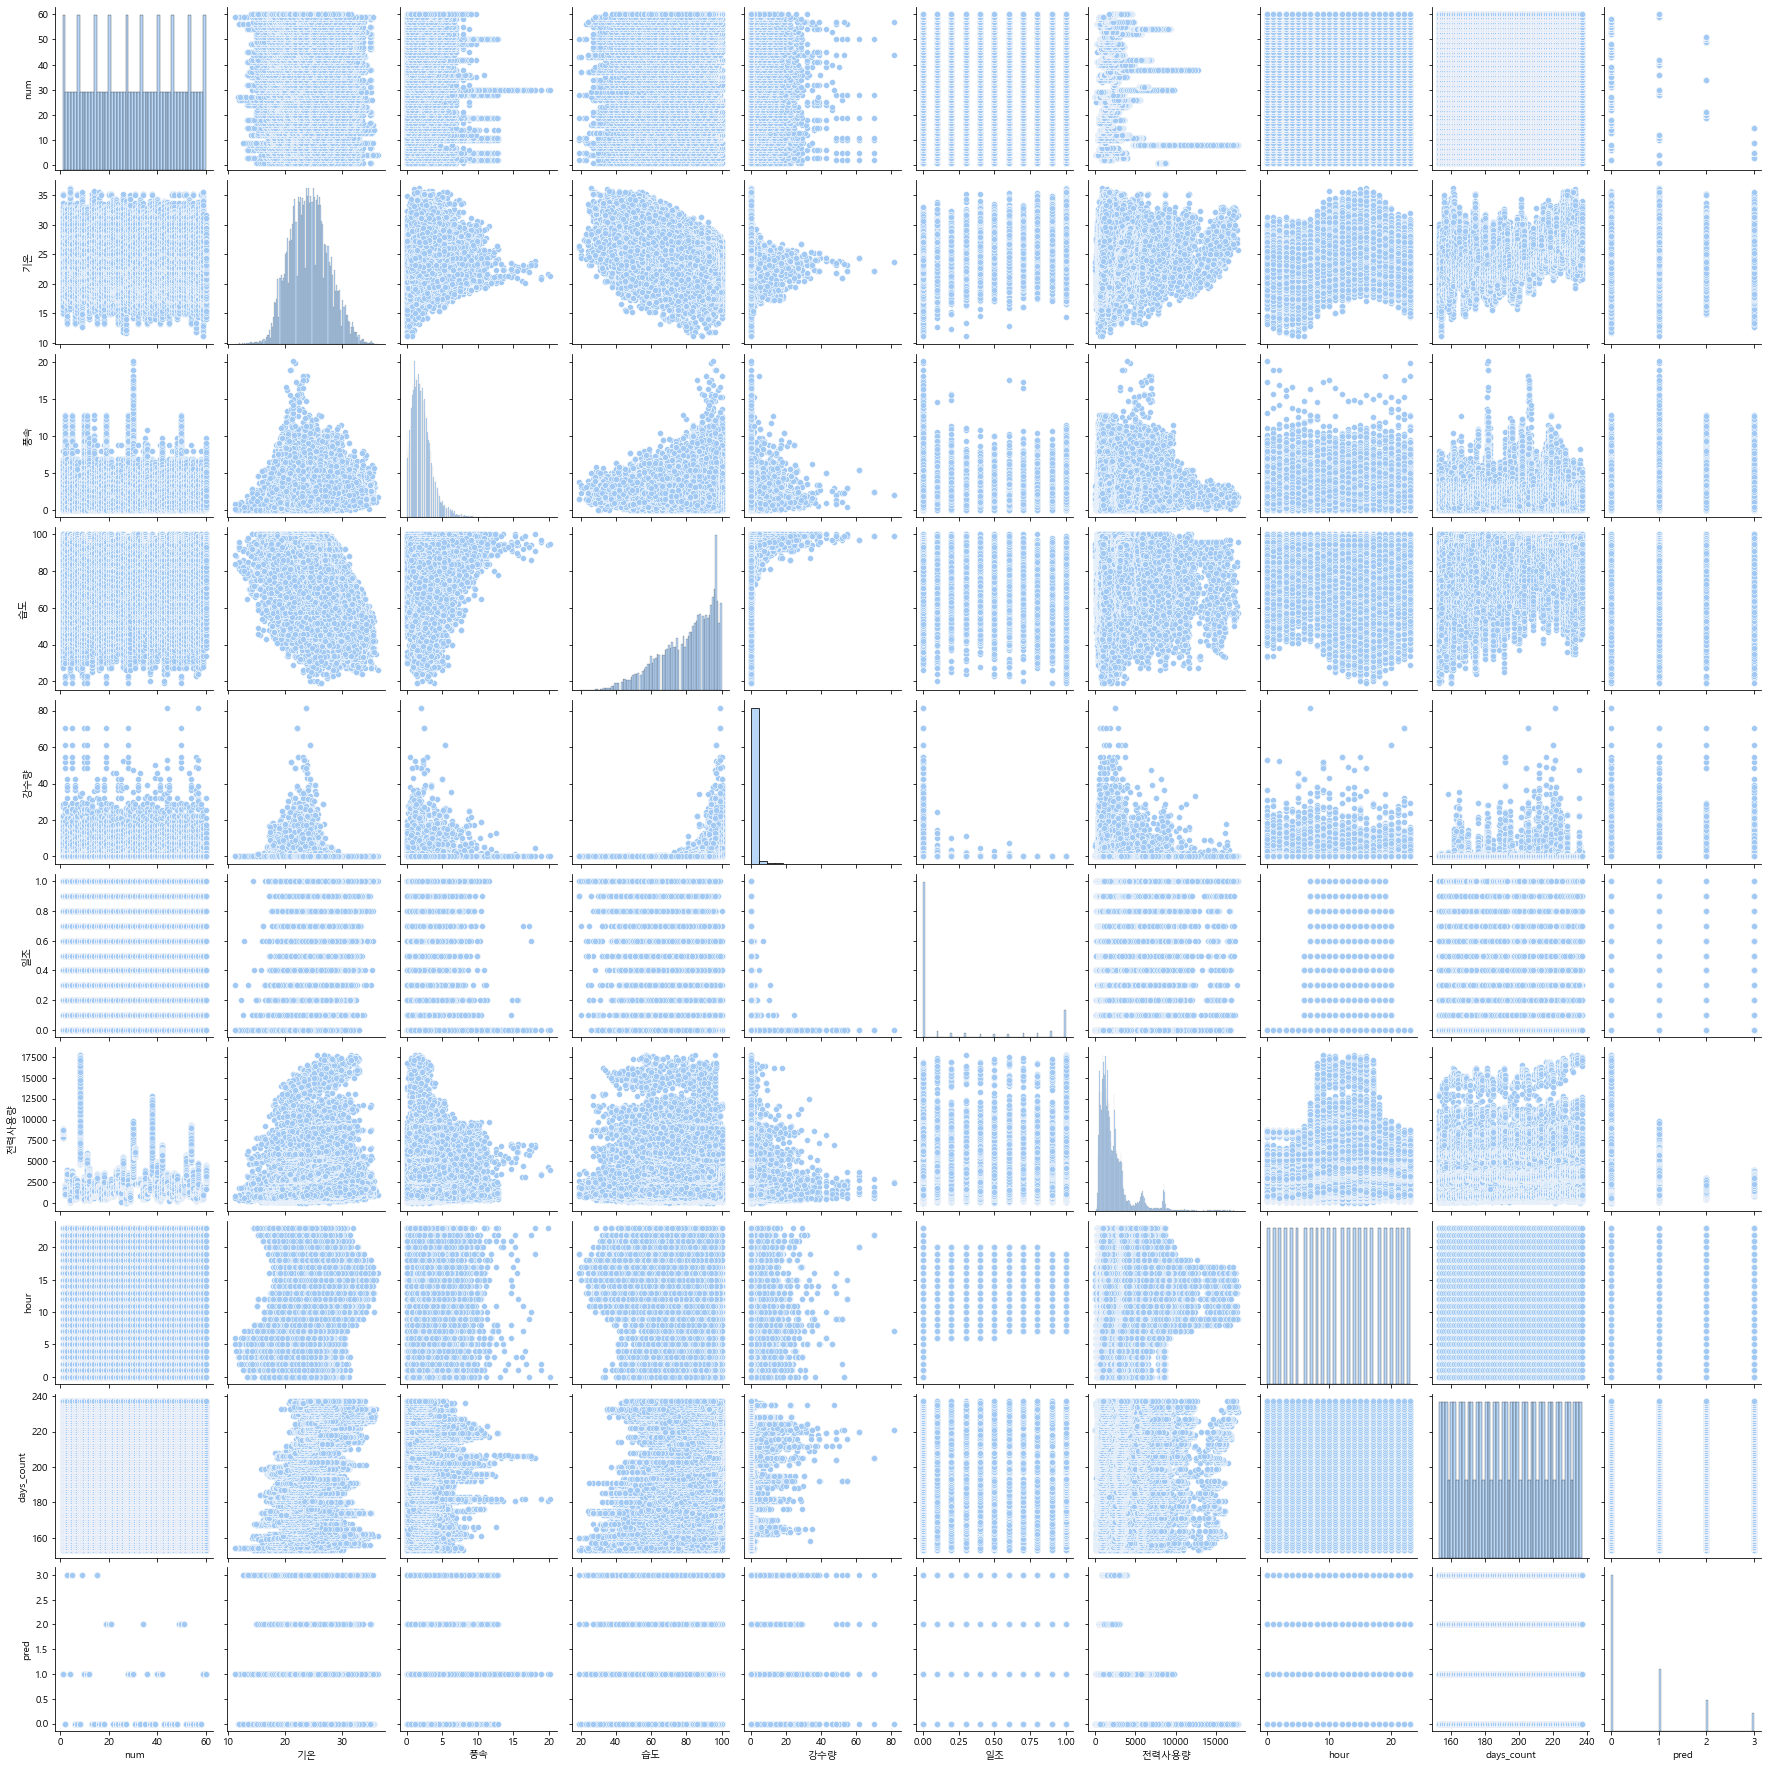

In [60]:
sns.pairplot(copy_train)
plt.show()

풍속과 습도가 치우쳐져있음.

In [61]:
# 불쾌지수 변수 생성
def make_temp(temp,humidity) :
    te = 0
    te = temp * 1.8 - 0.55*(1-(humidity/100))*(1.8*temp - 26) + 32
    return te

In [62]:
temp = copy_train['기온']
humidity = copy_train['습도']
copy_train['불쾌지수'] = make_temp(temp,humidity)

In [63]:
temp1 = copy_test['기온']
humidity1 = copy_test['습도']
copy_test['불쾌지수'] = make_temp(temp1, humidity1)

In [64]:
copy_train

,num,기온,풍속,습도,강수량,일조,전력사용량,hour,days_count,pred,불쾌지수
0,1,17.6,2.5,92.0,0.8,0.0,8179.056,0,153,1,63.43008
1,1,17.7,2.9,91.0,0.3,0.0,8135.640,1,153,1,63.56993
2,1,17.5,3.2,91.0,0.0,0.0,8107.128,2,153,1,63.22775
3,1,17.1,3.2,91.0,0.0,0.0,8048.808,3,153,1,62.54339
4,1,17.0,3.3,92.0,0.0,0.0,8043.624,4,153,1,62.39760
...,...,...,...,...,...,...,...,...,...,...,...
122395,60,27.8,2.3,68.0,0.0,0.7,4114.368,19,237,1,77.80896
122396,60,27.3,1.2,71.0,0.0,0.0,3975.696,20,237,1,77.44917
122397,60,27.3,1.8,71.0,0.0,0.0,3572.208,21,237,1,77.44917
122398,60,27.1,1.8,74.0,0.0,0.0,3299.184,22,237,1,77.52246


In [65]:
copy_train['불쾌지수_등급'] = 0
copy_test['불쾌지수_등급'] = 0

In [66]:
for idx,i in enumerate(copy_train['불쾌지수']) :
    if i < 68 :
        copy_train.loc[idx,'불쾌지수_등급'] = 1
    elif i < 75 :
        copy_train.loc[idx,'불쾌지수_등급'] = 2
    elif i < 80 :
        copy_train.loc[idx,'불쾌지수_등급'] = 3
    else :
        copy_train.loc[idx,'불쾌지수_등급'] = 4

In [67]:
for idx,i in enumerate(copy_test['불쾌지수']) :
    if i < 68 :
        copy_test.loc[idx,'불쾌지수_등급'] = 1
    elif i < 75 :
        copy_test.loc[idx,'불쾌지수_등급'] = 2
    elif i < 80 :
        copy_test.loc[idx,'불쾌지수_등급'] = 3
    else :
        copy_test.loc[idx,'불쾌지수_등급'] = 4

In [68]:
copy_train

,num,기온,풍속,습도,강수량,일조,전력사용량,hour,days_count,pred,불쾌지수,불쾌지수_등급
0,1,17.6,2.5,92.0,0.8,0.0,8179.056,0,153,1,63.43008,1
1,1,17.7,2.9,91.0,0.3,0.0,8135.640,1,153,1,63.56993,1
2,1,17.5,3.2,91.0,0.0,0.0,8107.128,2,153,1,63.22775,1
3,1,17.1,3.2,91.0,0.0,0.0,8048.808,3,153,1,62.54339,1
4,1,17.0,3.3,92.0,0.0,0.0,8043.624,4,153,1,62.39760,1
...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,27.8,2.3,68.0,0.0,0.7,4114.368,19,237,1,77.80896,3
122396,60,27.3,1.2,71.0,0.0,0.0,3975.696,20,237,1,77.44917,3
122397,60,27.3,1.8,71.0,0.0,0.0,3572.208,21,237,1,77.44917,3
122398,60,27.1,1.8,74.0,0.0,0.0,3299.184,22,237,1,77.52246,3


In [69]:
copy_train['불쾌지수'].describe()

count    122400.000000
mean         73.461061
std           4.778330
min          52.344210
25%          70.035960
50%          73.615850
75%          77.074510
max          86.661790
Name: 불쾌지수, dtype: float64

In [70]:
copy_train

,num,기온,풍속,습도,강수량,일조,전력사용량,hour,days_count,pred,불쾌지수,불쾌지수_등급
0,1,17.6,2.5,92.0,0.8,0.0,8179.056,0,153,1,63.43008,1
1,1,17.7,2.9,91.0,0.3,0.0,8135.640,1,153,1,63.56993,1
2,1,17.5,3.2,91.0,0.0,0.0,8107.128,2,153,1,63.22775,1
3,1,17.1,3.2,91.0,0.0,0.0,8048.808,3,153,1,62.54339,1
4,1,17.0,3.3,92.0,0.0,0.0,8043.624,4,153,1,62.39760,1
...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,27.8,2.3,68.0,0.0,0.7,4114.368,19,237,1,77.80896,3
122396,60,27.3,1.2,71.0,0.0,0.0,3975.696,20,237,1,77.44917,3
122397,60,27.3,1.8,71.0,0.0,0.0,3572.208,21,237,1,77.44917,3
122398,60,27.1,1.8,74.0,0.0,0.0,3299.184,22,237,1,77.52246,3


In [71]:
copy_days = copy_train.groupby(['num','days_count'])['전력사용량'].mean().reset_index().reset_index().pivot('num','days_count','전력사용량')

In [72]:
copy_train.groupby(['num','days_count'])['전력사용량','기온'].mean().reset_index()

,num,days_count,전력사용량,기온
0,1,153,8049.780,19.841667
1,1,154,7958.169,17.900000
2,1,155,8269.614,21.841667
3,1,156,8459.748,21.908333
4,1,157,8611.461,22.862500
...,...,...,...,...
5095,60,233,3750.012,26.525000
5096,60,234,3687.966,26.283333
5097,60,235,3540.636,25.283333
5098,60,236,3461.076,25.254167


In [73]:
copy_days.iloc[0]

days_count
153    8049.7800
154    7958.1690
155    8269.6140
156    8459.7480
157    8611.4610
         ...    
233    8678.4210
234    8683.5510
235    8597.2215
236    8545.8510
237    8652.2580
Name: 1, Length: 85, dtype: float64

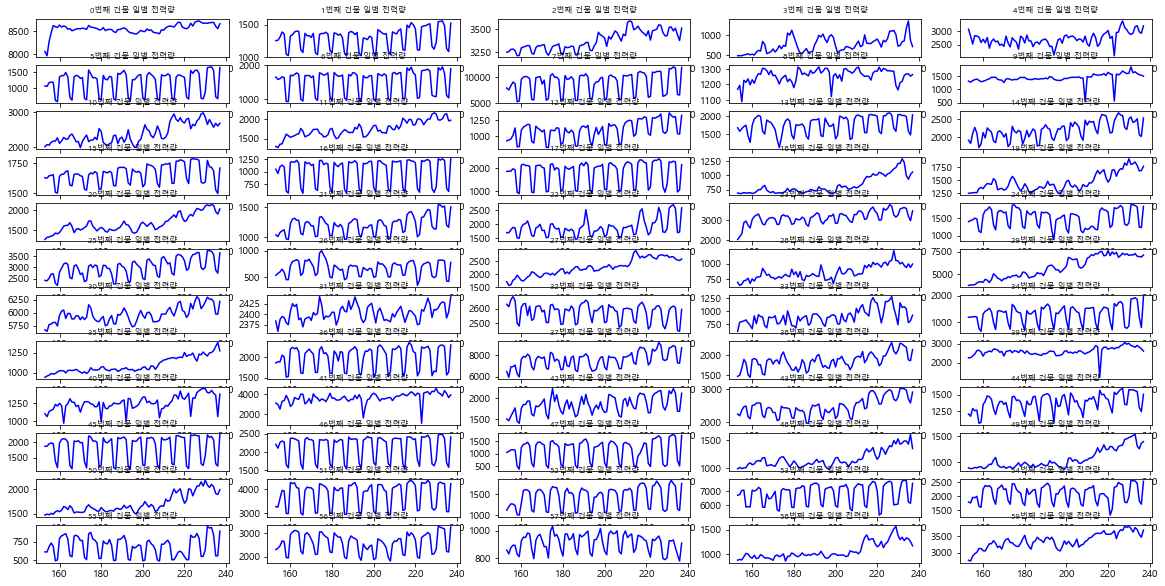

In [74]:
plt.figure(figsize = (20,10))
for i in range(0,60) :
    plt.subplot(12,5,i+1)
    plt.plot(np.arange(153,238),copy_days.iloc[i], 'b')
    plt.title('{}번째 건물 일별 전력량'.format(i), fontsize = 8)

    
plt.show()

여름에 가까워질수록 전력 사용량이 증가하는 건물(2,18, 50)이 있으며, 계절에 상관없이 꾸준한 전력 사용량을 보이는 건물도 있음.

In [75]:
copy_days = copy_train.groupby(['pred','days_count'])['전력사용량'].mean().reset_index().reset_index().pivot('pred','days_count','전력사용량')

In [76]:
copy_temp = copy_train.groupby(['pred','days_count'])['기온'].mean().reset_index().reset_index().pivot('pred','days_count','기온')

In [77]:
len(copy_days.columns)+ 153

238

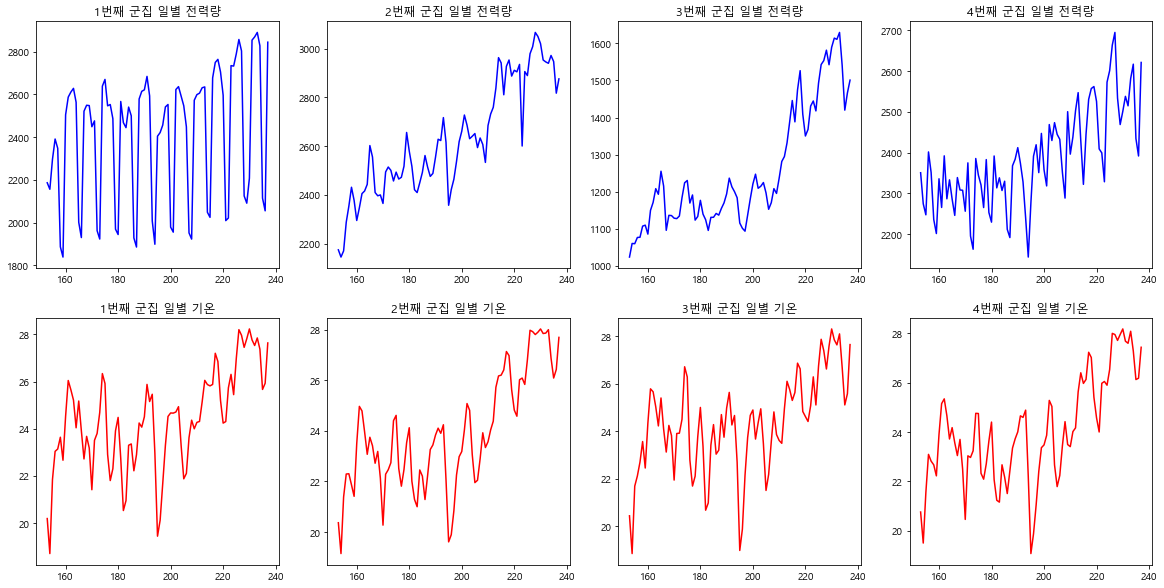

In [78]:
plt.figure(figsize = (20,10))
for i in range(0,4) :
    plt.subplot(2,4,i+1)
    plt.plot(np.arange(153,len(copy_days.columns) + 153), copy_days.iloc[i], 'b')
    plt.title('{}번째 군집 일별 전력량'.format(i+1))
    plt.subplot(2,4,i+5)
    plt.plot(np.arange(153,len(copy_temp.columns) + 153), copy_temp.iloc[i], 'r')
    plt.title('{}번째 군집 일별 기온'.format(i+1))
plt.show()

1번 군집을 재외하고는 기온이 올라갈수록 전력사용량도 증가하는 모습을 보임.

#### train, test set 분리
- 클러스터 비율이 다르기에 StratifiedKFold 사용

***
- **train** : train 데이터셋에서 0.8 비율


- **valid** : train에서 0.2 비율


- **test** : test 데이터셋 사용
***

In [79]:
train_pred['불쾌지수'] = copy_train['불쾌지수']
train_pred['불쾌지수_등급'] = copy_train['불쾌지수_등급']

In [110]:
train_pred

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,date,hour,week,weekend,days_count,pred,불쾌지수,불쾌지수_등급
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01,0,0,0,153,1,63.43008,1
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01,1,0,0,153,1,63.56993,1
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,2,0,0,153,1,63.22775,1
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,3,0,0,153,1,62.54339,1
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01,4,0,0,153,1,62.39760,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,2020-08-24,19,0,0,237,1,77.80896,3
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,2020-08-24,20,0,0,237,1,77.44917,3
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,2020-08-24,21,0,0,237,1,77.44917,3
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,2020-08-24,22,0,0,237,1,77.52246,3


In [111]:
X = train_pred.drop(['date_time','전력사용량','date','태양광보유'], axis = 1)
y = train_pred['전력사용량']

In [112]:
X_test = test_df.drop(['date_time','date','태양광보유'],axis = 1)

In [113]:
X_test = pd.merge(X_test,df_all[['num','pred']], on = 'num',how = 'right')

In [114]:
def make_scale(df) :
    d = 0
    result = []
    for idx,i in enumerate(df) :
        d = (i - np.median(df))/np.std(df)
        result.append(d)
    return result

X['습도'] = make_scale(X['습도'])
X_test['습도'] = make_scale(X_test['습도'])

In [115]:
X_test['불쾌지수'] = copy_test['불쾌지수']
X_test['불쾌지수_등급'] = copy_test['불쾌지수_등급']

In [119]:
from sklearn.metrics import make_scorer  # loss function 커스터마이징
# SMAPE 정의
def smape(true, pred) :
    true = np.array(true)
    pred = np.array(pred)
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))  # *2 , *100은 상수이므로 생략
SMAPE = make_scorer(smape, greater_is_better=False)  # smape 값이 작아져야하므로 False

In [120]:
# StratifiedKFold 기반 분리
from sklearn.model_selection import StratifiedKFold
splits = StratifiedKFold(n_splits = 5)

그리드 서치 결과, 학습률 0.01, 노드 개수 1000개일 때 가장 점수가 높게 나타났다.(lgbm) 참조

In [121]:
from lightgbm import LGBMRegressor
n_iter = 0
n_splits = 5
y_pred = np.zeros(len(X_test))
for train_idx, valid_idx in splits.split(X,X['num']) :
    n_iter += 1
    X_train = X.iloc[train_idx, :]
    y_train = y[train_idx]
    
    X_val = X.iloc[valid_idx, : ]
    y_val = y[valid_idx]
    print("-----{}번째 교차검증-----".format(n_iter), end = '\n')
    print("X_train 교차검증 개수: \n{}".format(len(X_train.value_counts())),end = '\n')
    print("y_train 교차검증 개수: \n{}".format(len(y_train.value_counts())), end = '\n\n')
    
    lgbm = LGBMRegressor(n_estimators = 1000, learning_rate = 0.01, objective = 'mse')
    lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= 'rmse', early_stopping_rounds= 50,verbose = 100)
    y_pred += lgbm.predict(X_test) / n_splits

-----1번째 교차검증-----
X_train 교차검증 개수: 
97920
y_train 교차검증 개수: 
46610

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 1007.96	valid_0's l2: 1.01598e+06
[200]	valid_0's rmse: 674.898	valid_0's l2: 455487
[300]	valid_0's rmse: 524.925	valid_0's l2: 275546
[400]	valid_0's rmse: 453.946	valid_0's l2: 206067
[500]	valid_0's rmse: 408.83	valid_0's l2: 167142
[600]	valid_0's rmse: 382.115	valid_0's l2: 146012
[700]	valid_0's rmse: 365.534	valid_0's l2: 133615
[800]	valid_0's rmse: 353.957	valid_0's l2: 125286
[900]	valid_0's rmse: 341.55	valid_0's l2: 116656
[1000]	valid_0's rmse: 333.971	valid_0's l2: 111537
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 333.971	valid_0's l2: 111537
-----2번째 교차검증-----
X_train 교차검증 개수: 
97920
y_train 교차검증 개수: 
46674

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 1067.42	valid_0's l2: 1.13938e+06
[200]	valid_0's rmse: 713.567	valid_0's l2: 509178
[300]	valid_0's rmse:

In [122]:
import xgboost as xgb
from xgboost import plot_importance

n_iter = 0
n_splits = 5
y_pred = np.zeros(len(X_test))
for train_idx, valid_idx in splits.split(X,X['num']) :
    n_iter += 1
    X_train = X.iloc[train_idx, :]
    y_train = y[train_idx]
    
    X_val = X.iloc[valid_idx, : ]
    y_val = y[valid_idx]
    print("-----{}번째 교차검증-----".format(n_iter), end = '\n')
    print("X_train 교차검증 개수: \n{}".format(len(X_train.value_counts())),end = '\n')
    print("y_train 교차검증 개수: \n{}".format(len(y_train.value_counts())), end = '\n\n')
    
    xgb_re = xgb.XGBRegressor(n_estimators = 1000, learning_rate = 0.01)
    xgb_re.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= 'rmse', early_stopping_rounds= 50,verbose = 100)
    y_pred += lgbm.predict(X_test) / n_splits

-----1번째 교차검증-----
X_train 교차검증 개수: 
97920
y_train 교차검증 개수: 
46610

[0]	validation_0-rmse:2906.83179
[100]	validation_0-rmse:1469.88062
[200]	validation_0-rmse:1012.25861
[300]	validation_0-rmse:758.89917
[400]	validation_0-rmse:602.64081
[500]	validation_0-rmse:527.26129
[600]	validation_0-rmse:482.95160
[700]	validation_0-rmse:439.96820
[800]	validation_0-rmse:406.95740
[900]	validation_0-rmse:381.23450
[999]	validation_0-rmse:362.25916
-----2번째 교차검증-----
X_train 교차검증 개수: 
97920
y_train 교차검증 개수: 
46674

[0]	validation_0-rmse:2972.81348
[100]	validation_0-rmse:1543.16834
[200]	validation_0-rmse:1090.56213
[300]	validation_0-rmse:796.66345
[400]	validation_0-rmse:630.46234
[500]	validation_0-rmse:539.39508
[600]	validation_0-rmse:481.18845
[700]	validation_0-rmse:433.71600
[800]	validation_0-rmse:393.87378
[900]	validation_0-rmse:362.49262
[999]	validation_0-rmse:336.06613
-----3번째 교차검증-----
X_train 교차검증 개수: 
97920
y_train 교차검증 개수: 
46339

[0]	validation_0-rmse:3023.90161
[100]	validat

<Figure size 1440x720 with 0 Axes>

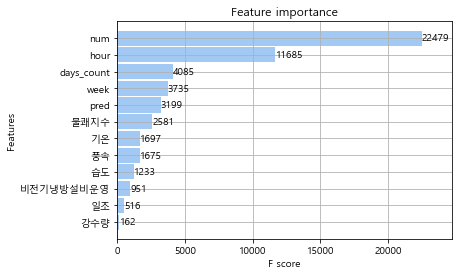

In [128]:
plt.figure(figsize = (20,10))
plot_importance(xgb_re, height=0.9) 
plt.show()

In [123]:
y_pred1 = lgbm.predict(X_val)
y_pred2 = xgb_re.predict(X_val)

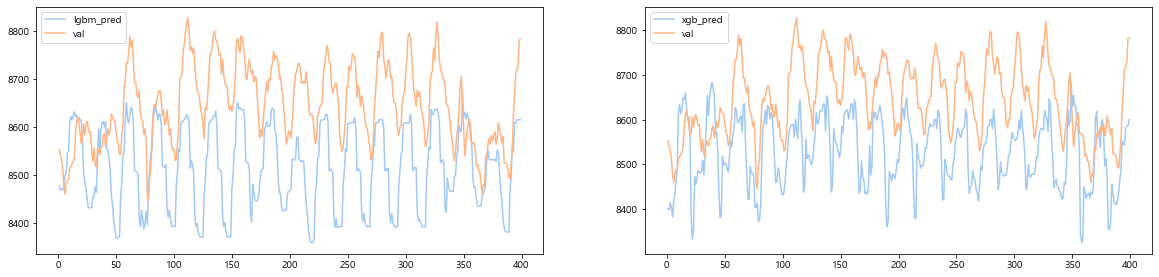

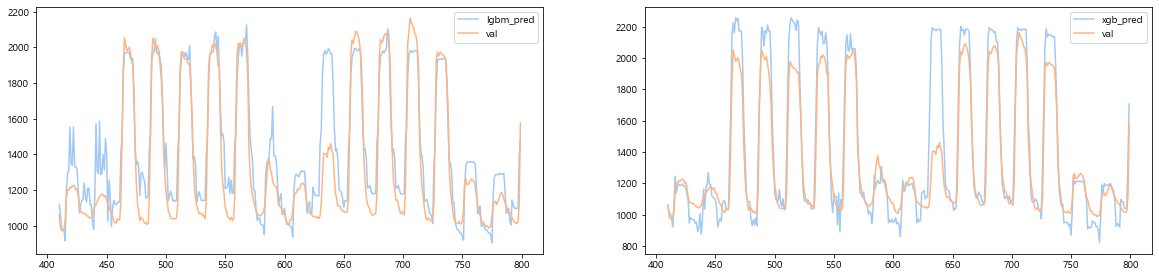

In [124]:
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.plot(np.arange(1,400),y_pred1[1:400], label = 'lgbm_pred')
plt.plot(np.arange(1,400),y_val[1:400], label = 'val' )
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(1,400),y_pred2[1:400], label = 'xgb_pred')
plt.plot(np.arange(1,400),y_val[1:400], label = 'val' )
plt.legend()

plt.figure(figsize = (20,10))
plt.subplot(2,2,3)
plt.plot(np.arange(410,800),y_pred1[410:800], label = 'lgbm_pred')
plt.plot(np.arange(410,800),y_val[410:800], label = 'val' )
plt.legend()

plt.subplot(2,2,4)
plt.plot(np.arange(410,800),y_pred2[410:800], label = 'xgb_pred')
plt.plot(np.arange(410,800),y_val[410:800], label = 'val' )
plt.legend()
plt.show()

In [92]:
y_pred = lgbm.predict(X_test)
y_pred1 = xgb_re.predict(X_test)

In [ ]:
y_submission = pd.DataFrame(y_pred)

In [ ]:
y_submission

In [ ]:
sub = submission_df.copy()
sub['answer'] = y_pred

In [ ]:
sub.to_csv('./y_submission.csv')